Decision Tree algorithm

In [239]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import plot_tree
from typing import Any

In [240]:
class MyDecisionTree(BaseEstimator, ClassifierMixin):

    class TreeNode:
        def __init__(
            self,
            entropy: float,
            cl_counts: np.ndarray,
            cl_names: np.ndarray,
            feature_name: Any,
            feature_index: int
        ):
            self.entropy = entropy
            self.cl_counts = cl_counts
            self.cl_names = cl_names
            self.feature_name = feature_name
            self.feature_index = feature_index
            self.cl_name = None
            self.children = []

        def print_tree(self, indent=0):
            print(("\t" * indent) + f"({self.entropy}, {self.cl_counts}, {self.cl_names}, {self.feature_index}, {self.feature_name}, {self.cl_name})")
            for child in self.children:
                child.print_tree(indent+1)

        def is_leaf(self):
            return len(self.children) == 0


    def fit(self, x_train, y_train):
        self.n_features_ = x_train.shape[1]

        class_names, class_counts = np.unique(y_train, return_counts=True)
        
        self.root_ = MyDecisionTree.TreeNode(
            entropy=self._entropy(y_train),
            cl_counts=class_counts,
            cl_names=class_names,
            feature_name=None,
            feature_index=None
        )

        self.root_.children = self._id3(
            self.root_,
            np.array(x_train),
            np.array(y_train),
        )

        return self

    def predict(self, x_tests):
        return np.array([self._predict_one(self.root_, x_test) for x_test in x_tests])

    def _predict_one(self, parent: TreeNode, x_test: np.ndarray):
        if parent.is_leaf():
            return parent.cl_name
        else:
            next_child = next(child for child in parent.children if child.feature_name == x_test[child.feature_index])
            return self._predict_one(next_child, x_test)

    def _id3(self, parent: TreeNode, xs: np.ndarray, ys: np.ndarray): 
        if len(parent.cl_counts) == 1:
            parent.cl_name = parent.cl_names[0]
            return []

        igs = []
        for ift in range(self.n_features_):
            ig = 0
            for feature_name in np.unique(xs[:, ift]):
                ys_part = ys[xs[:, ift] == feature_name]
                ig += self._entropy(ys_part) * ys_part.size / ys.size
            igs.append(parent.entropy - ig)
        
        ift_max = np.argmax(igs)

        children = []
        for feature_name in np.unique(xs[:, ift_max]):
            xs_part = xs[xs[:, ift_max] == feature_name]
            ys_part = ys[xs[:, ift_max] == feature_name]
            class_names, class_counts = np.unique(ys_part, return_counts=True)
            node = MyDecisionTree.TreeNode(
                entropy=self._entropy(ys_part),
                cl_counts=class_counts,
                cl_names=class_names,
                feature_name=feature_name,
                feature_index=ift_max,
            )
            node.children = self._id3(node, xs_part, ys_part)
            children.append(node)

        return children

    def _entropy(self, ys):
        ps = np.unique(ys, return_counts=True)[1]
        ps = np.array([p for p in ps if p != 0])
        ps = ps / ys.size
        return -np.sum(ps*np.log2(ps))


In [241]:
restaurant = pd.read_csv('restaurant.csv', header = 0, index_col = 0)
y = restaurant.pop('WillWait?').values
x = restaurant.values

In [242]:
mdt = MyDecisionTree()
mdt.fit(x, y)

mdt.root_.print_tree()
print(mdt.predict(x))
print(y)

(1.0, [6 6], ['No' 'Yes'], None, None, None)
	(0.9182958340544896, [4 2], ['No' 'Yes'], 4, Full, None)
		(-0.0, [2], ['No'], 3, No, No)
		(1.0, [2 2], ['No' 'Yes'], 3, Yes, None)
			(-0.0, [1], ['Yes'], 8, Burger, Yes)
			(-0.0, [1], ['No'], 8, Italian, No)
			(1.0, [1 1], ['No' 'Yes'], 8, Thai, None)
				(-0.0, [1], ['No'], 2, No, No)
				(-0.0, [1], ['Yes'], 2, Yes, Yes)
	(-0.0, [2], ['No'], 4, None, No)
	(-0.0, [4], ['Yes'], 4, Some, Yes)
['Yes' 'No' 'Yes' 'Yes' 'No' 'Yes' 'No' 'Yes' 'No' 'No' 'No' 'Yes']
['Yes' 'No' 'Yes' 'Yes' 'No' 'Yes' 'No' 'Yes' 'No' 'No' 'No' 'Yes']


[Text(239.14285714285714, 199.32, 'X[10] <= 0.5\ngini = 0.5\nsamples = 12\nvalue = [6, 6]'),
 Text(191.31428571428572, 163.07999999999998, 'X[6] <= 0.5\ngini = 0.375\nsamples = 8\nvalue = [6, 2]'),
 Text(143.4857142857143, 126.83999999999999, 'X[18] <= 0.5\ngini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(95.65714285714286, 90.6, 'X[11] <= 0.5\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(47.82857142857143, 54.359999999999985, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(143.4857142857143, 54.359999999999985, 'X[23] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(95.65714285714286, 18.119999999999976, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(191.31428571428572, 18.119999999999976, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(191.31428571428572, 90.6, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(239.14285714285714, 126.83999999999999, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(286.9714285714286, 163.07999999999998, 'gini = 0.0\nsamples = 4\n

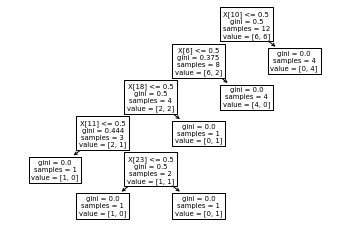

In [243]:
mdt = DecisionTreeClassifier(criterion='gini')
mdt.fit(OneHotEncoder().fit_transform(x), y)
plot_tree(mdt)